## 4.10 Homework 4: Evaluation Metrics for Classification

In [580]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

from IPython.display import display # displaying certain variables on purpose

# Disable scientific notation
np.set_printoptions(suppress=True, precision=2)

# Allow plotting of all subplots in a jupyter notebook
%matplotlib inline

### Dataset

In this homework, we will use the Bank Marketing dataset.
Download it from https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

We need bank-full.csv.

In this dataset the target variable is y variable - has the client subscribed a term deposit or not.

In [583]:
# Read the dataset
df_banks = pd.read_csv('bank-full.csv', delimiter=';')

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

- age,
- job,
- marital,
- education,
- balance,
- housing,
- contact,
- day,
- month,
- duration,
- campaign,
- pdays,
- previous,
- poutcome,
- y

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [586]:
# Check the column names
df_banks.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [588]:
# Select only the features from above
df_banks_features = df_banks[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]
df_banks_features

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [590]:
# Convert target variable 'y' to binary
df_banks_features['y'] = df_banks_features['y'].apply(lambda x: 1 if x == 'yes' else 0)
df_banks_features

C:\Users\Christopher\AppData\Local\Temp\ipykernel_27884\1892967155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_banks_features['y'] = df_banks_features['y'].apply(lambda x: 1 if x == 'yes' else 0)


,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,0


In [596]:
# Splitting the dataset into two parts 80% (df_train_full) + 20% (df_test)
df_train_full, df_test = train_test_split(df_banks_features, test_size=0.2, random_state=1)

In [598]:
len(df_train_full), len(df_test)

(36168, 9043)

In [600]:
# Splitting the df_train_full into training and validation 60% (train) + 20% (val) (20% of 80% = 25%)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [602]:
len(df_train), len(df_val)

(27126, 9042)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [605]:
# List of numerical variables
numerical_vars = ['balance', 'day', 'duration', 'previous']

In [607]:
# Calculate ROC AUC for each numerical variable
auc_scores = {}
for var in numerical_vars:
    auc = roc_auc_score(df_train['y'], df_train[var])
    # If AUC is less than 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[var])
    auc_scores[var] = auc

In [609]:
# Find the variable with the highest AUC
max_auc_var = max(auc_scores, key=auc_scores.get)
print(f"Variable with highest AUC: {max_auc_var}")
print(f"AUC Scores: {auc_scores}")

Variable with highest AUC: duration
AUC Scores: {'balance': 0.5888313805382317, 'day': 0.525957882383908, 'duration': 0.8147002759670778, 'previous': 0.5985653242764153}


#### Question 1 - Answer: duration

### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [613]:
# Prepare the data for one-hot encoding
dv = DictVectorizer(sparse=False)

In [615]:
# Convert the training and validation data to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [617]:
# Apply one-hot encoding
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [618]:
# Prepare the target variable
y_train = df_train['y'].values
y_val = df_val['y'].values

In [619]:
# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [623]:
# Predict probabilities for the validation dataset
y_pred = model.predict_proba(X_val)[:, 1]

In [625]:
# Calculate the AUC score
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation set: {auc:.3f}")
print(f"AUC on validation set: {auc:}")

AUC on validation set: 1.000
AUC on validation set: 0.9999998853541273


In [627]:
# Double check: Confirm that y variables are not all set to zero and confirm their proportions
print(y_pred.mean())
print(y_val.mean())
print(round((y_pred.mean() / y_val.mean()), 3))

0.1215188261748407
0.12143331121433311
1.001


#### Question 2 - Answer: 0.99

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

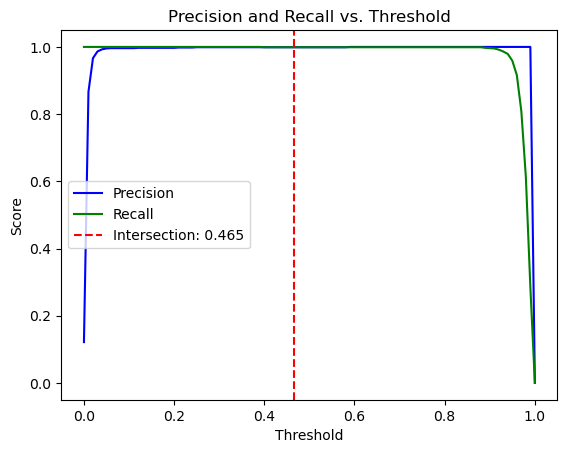

Threshold where precision and recall intersect (rounded): 0.4


In [635]:
# Define thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Prepare lists to store precision and recall values
precisions = []
recalls = []

# Loop through each threshold
for threshold in thresholds:
    # Classify predictions based on the threshold
    y_pred_class = (y_pred >= threshold).astype(int)
    
    # Compute precision and recall for the threshold
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class)
    
    # Store the results
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label=f'Intersection: {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

# Find the threshold where precision and recall curves intersect
precisions = np.array(precisions)
recalls = np.array(recalls)
diffs = np.abs(precisions - recalls)
intersection_index = np.argmin(diffs)
intersection_threshold = thresholds[intersection_index]

# Round the threshold to 3 digits to compare with answer options
intersection_threshold_rounded = round(intersection_threshold, 4)

print(f"Threshold where precision and recall intersect (rounded): {intersection_threshold_rounded}")

Threshold: 0.265, Precision: 0.999, Recall: 1.000
Threshold: 0.465, Precision: 0.999, Recall: 0.999
Threshold: 0.665, Precision: 1.000, Recall: 0.999
Threshold: 0.865, Precision: 1.000, Recall: 0.999
Threshold where precision and recall intersect (rounded): 0.465


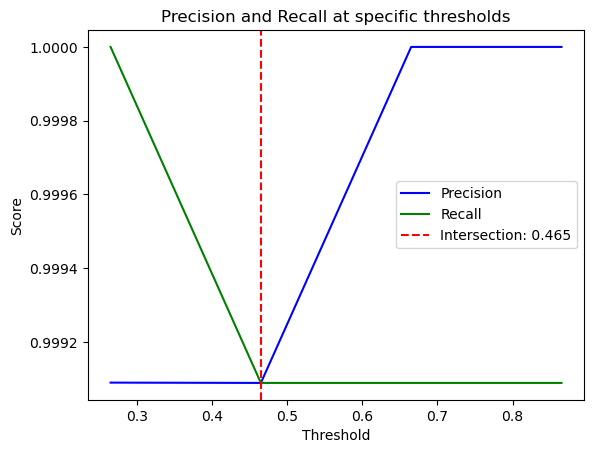

In [637]:
# Four possible thresholds
thresholds = [0.265, 0.465, 0.665, 0.865]

# Prepare lists to store precision and recall values
precisions = []
recalls = []

# Loop through each threshold
for threshold in thresholds:
    # Classify predictions based on the threshold
    y_pred_class = (y_pred >= threshold).astype(int)
    
    # Compute precision and recall for the threshold
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class)
    
    # Store the results
    precisions.append(precision)
    recalls.append(recall)

# Display the precision and recall for each threshold
for i, threshold in enumerate(thresholds):
    print(f"Threshold: {threshold}, Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}")

# Find the threshold where precision and recall curves intersect
precisions = np.array(precisions)
recalls = np.array(recalls)
diffs = np.abs(precisions - recalls)
intersection_index = np.argmin(diffs)
intersection_threshold = thresholds[intersection_index]

# Round the threshold to 3 digits to compare with answer options
intersection_threshold_rounded = round(intersection_threshold, 4)

print(f"Threshold where precision and recall intersect (rounded): {intersection_threshold_rounded}")

# Plot precision and recall curves for these four thresholds
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label=f'Intersection: {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall at specific thresholds')
plt.legend()
plt.show()

#### Question 3 - Answer: 0.465

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

    F 1 = 2 ⋅ P ⋅ R P + R

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

Threshold: 0.02, F1 Score: 0.983
Threshold: 0.22, F1 Score: 0.999
Threshold: 0.42, F1 Score: 0.999
Threshold: 0.62, F1 Score: 1.000


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

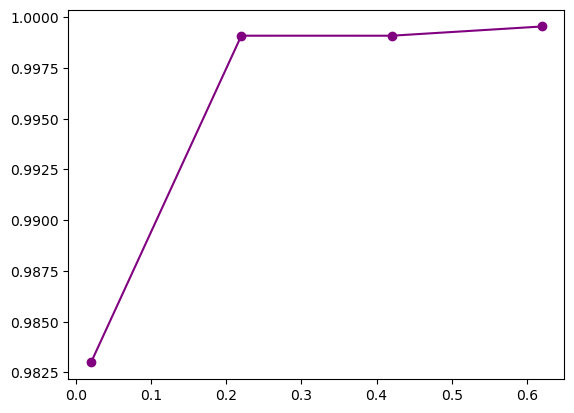

In [641]:
# Four possible thresholds
thresholds = [0.02, 0.22, 0.42, 0.62]

# Prepare list to store F1 scores
f1_scores = []

# Loop through each threshold
for threshold in thresholds:
    # Classify predictions based on the threshold
    y_pred_class = (y_pred >= threshold).astype(int)
    
    # Compute precision and recall for the threshold
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class)
    
    # Compute F1 score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0  # If both precision and recall are 0, F1 is 0
    
    # Store the F1 score
    f1_scores.append(f1)

# Display the F1 score for each threshold
for i, threshold in enumerate(thresholds):
    print(f"Threshold: {threshold}, F1 Score: {f1_scores[i]:.3f}")

# Plot F1 score for these specific thresholds
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple', marker='o')
plt

#### Question 4 - Answer: 0.62

### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)


- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [645]:
# Prepare the features and target
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
X = df_train_full[features]
y = df_train_full['y']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize list to store AUC scores
auc_scores = []

# Iterate over different folds
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Convert the training and validation data into dictionaries
    train_dicts = X_train.to_dict(orient='records')
    val_dicts = X_val.to_dict(orient='records')

    # One-hot encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(train_dicts)
    X_val_encoded = dv.transform(val_dicts)

    # Train Logistic Regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)

    # Predict probabilities for validation set
    y_pred = model.predict_proba(X_val_encoded)[:, 1]

    # Compute AUC score
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores across folds
auc_std = np.std(auc_scores)

# Output the standard deviation
print(f"Standard deviation of AUC scores across folds: {auc_std:.3f}")

Standard deviation of AUC scores across folds: 0.006


#### Question 5 - Answer: 0.006

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [654]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

# Define the values of C to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare the features and target (assuming df_full_train is ready)
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
X = df_train_full[features]
y = df_train_full['y']

# Dictionary to store mean and std AUC scores for each C value
results = {}

# Iterate over each C value
for C in C_values:
    auc_scores = []
    
    # Perform KFold cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Convert the training and validation data into dictionaries
        train_dicts = X_train.to_dict(orient='records')
        val_dicts = X_val.to_dict(orient='records')

        # One-hot encoding using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train_encoded = dv.fit_transform(train_dicts)
        X_val_encoded = dv.transform(val_dicts)

        # Train Logistic Regression model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)

        # Predict probabilities for validation set
        y_pred = model.predict_proba(X_val_encoded)[:, 1]

        # Compute AUC score
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    # Compute mean and std of AUC scores for the current C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store the results (rounded to 3 decimal places)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

# Output the results
for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: Mean AUC={mean_auc}, Std AUC={std_auc}")

# Find the best C value based on mean AUC, then by std, and if still tied, the smallest C
best_C = min(results, key=lambda x: (results[x][0], -results[x][1], x))

print(f"Best C value: {best_C:.6f}")

C=1e-06: Mean AUC=0.701, Std AUC=0.009
C=0.001: Mean AUC=0.861, Std AUC=0.007
C=1: Mean AUC=0.906, Std AUC=0.006
Best C value: 0.000001


#### Question 6 - Answer: 0.000001